# Nonlinear Regression
In this example we will fit a model to a nonlinear data by performing gradient descent on a loss function
using PyTorch. Here the dataset we use is sinusoidal in nature.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt

**Create a dataset**

We construct a sine wave of the form
$$
Asin(Bx) + C
$$
then we add some Gaussian noise to it and save it to a CSV file. This will be our dataset which we will pretend we found in the wild. Through visual inspection we suppose it is sinusoidal.


In [2]:
# makes a noisy sine wave which we will try to fit a model to
A = 1
B = 3
C = 0
N = 100
x = np.linspace(0,2*np.pi,N)
y = A * np.sin(B * x) + C
y_noisy = y.copy()

deviation = 0.2
for i in range(len(y_noisy)):
    noise = np.random.uniform(-deviation, deviation)
    y_noisy[i] += noise

data_out = np.row_stack([x, y_noisy])
np.savetxt("./datasets/noisy_sine.csv", data_out, delimiter=",")

For a dataset and problem this simple we probably don't need to use the PyTorch Dataset and DataLoader,
however we choose to use it here for completeness/practice. In the constructor we read in the csv file
using `np.loadtxt`. We must implement `__len__` and `__getitem__` and we also create a `scatter_plot` method
to plot the raw data

In [3]:
class SinusoidalDataset(Dataset):
    def __init__(self, path):
        data = np.loadtxt(path,delimiter=",")
        self.inputs = torch.from_numpy(data[0,:]).float()
        self.outputs = torch.from_numpy(data[1,:]).float()

    def __len__(self):
        return (len(self.inputs))

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

    def scatter_plot(self):
        x = self.inputs.numpy()
        y = self.outputs.numpy()
        plt.figure(figsize=(5,3))
        plt.scatter(x,y)
        plt.grid()
        plt.show()

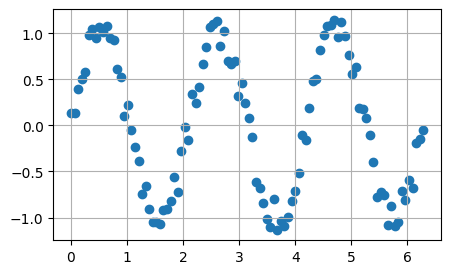

In [4]:
# load the dataset
training_data = SinusoidalDataset("./datasets/noisy_sine.csv")

# Show a plot of the raw data
training_data.scatter_plot()

# Create a DataLoader
dataloader = DataLoader(training_data)

**Define a Model**

As stated earlier, we will assume our data is of the form $Asin(Bx)+C$. For this data shown above, I think
it is reasonable that we could come up with this model simply by visual inspection so this is not far fetched
to assume we would know the model here.

We include a parameter to the constructor called `w0` which is a list that contains an initial guess at the
three weights, A, B, and C. If this list is empty the weights are selected randomly.

In [5]:
class SinusoidalModel(torch.nn.Module):
    '''
    Sinusoid of the form a*sin(b*x) + c
    '''
    def __init__(self,w0=[]):
        super().__init__()
        if len(w0) == 0:
            self.a = torch.nn.Parameter(torch.randn(()))
            self.b = torch.nn.Parameter(torch.randn(()))
            self.c = torch.nn.Parameter(torch.randn(()))
        else:
            self.a = torch.nn.Parameter(torch.tensor(w0[0], dtype=torch.float32, requires_grad=True))
            self.b = torch.nn.Parameter(torch.tensor(w0[1], dtype=torch.float32, requires_grad=True))
            self.c = torch.nn.Parameter(torch.tensor(w0[2], dtype=torch.float32, requires_grad=True))

    def forward(self, x):
        return self.a * torch.sin(self.b*x) + self.c

**Setup**

Now we setup the model, loss function, and optimizer. For the model, I have found that the initial weights
need to be chosen to be somewhat close (+-0.5 usually works) to the true values for the training to converge.
We choose the mean squared error loss because its simply and we use stochastic gradient descent for the
optimizer

In [6]:
# instatiate the model based on the size of the input data
# the initial guess needs to be pretty close to the real solution
model = SinusoidalModel([0.739452, 3.23412, 0.12])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

**Training**

Now we train out model to find the weights A, B, and C. 300 epochs seems to be sufficient.
The loss values are saved at each epoch and plotted at the end to show that it does indeed
attempt to minimize the loss.

99: 0.020766112953424454
199: 0.014046000316739082
299: 0.013147342018783092


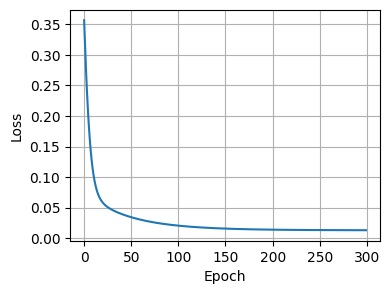

---------------
Found weights:
a = 1.0324337482452393
b = 2.99611234664917
c = 0.01519765518605709


In [7]:
# Train the model
loss_hist = []
features = dataloader.dataset.inputs
labels = dataloader.dataset.outputs
num_epochs = 300
for epoch in range(num_epochs):

    # Forward pass
    outputs = model(features.view(-1,1))

    # compuite the loss
    loss = criterion(outputs, labels.view(-1,1))
    loss_hist.append(loss.detach().float())
    if epoch % 100 == 99:
        print(f"{epoch}: {loss.item()}")

    # zero gradients, perform a backward pass, update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# plot loss history
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(list(range(num_epochs)), loss_hist)
ax.grid()
ax.set(xlabel="Epoch", ylabel="Loss")
plt.show()

a = model.a.item()
b = model.b.item()
c = model.c.item()
print("---------------")
print(f"Found weights:")
print(f"a = {model.a.item()}")
print(f"b = {model.b.item()}")
print(f"c = {model.c.item()}")


**Results**

Now that we have found the optimal weights, we plot the original dataset along with the optimized model

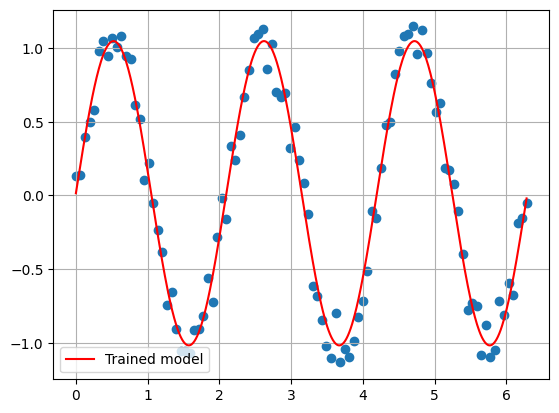

In [8]:
# Plot the trained model along with the raw data
xfit = np.arange(0,2*np.pi,0.01)
yfit = a*np.sin(b*xfit) + c
raw_x = dataloader.dataset.inputs.numpy().flatten()
raw_y = dataloader.dataset.outputs.numpy().flatten()

fig, ax = plt.subplots()
ax.scatter(raw_x, raw_y)
ax.plot(xfit, yfit, "-r", label="Trained model")
ax.grid()
ax.set()
ax.legend()
plt.show()